In [507]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

In [721]:
# imports 
%matplotlib inline
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype
from yellowbrick.features import FeatureImportances
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
import category_encoders as ce
import missingno as mno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [637]:
# read data 
df = pd.read_csv('./h1.csv')
df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,342,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,0,737,2015,July,27,1,0,0,2,0,...,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,0,7,2015,July,27,1,0,1,1,0,...,No Deposit,NULL,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,0,13,2015,July,27,1,0,1,1,0,...,No Deposit,304,NULL,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,0,14,2015,July,27,1,0,2,2,0,...,No Deposit,240,NULL,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [638]:
# Replace values containing the 'NULL' string with NaN values
null_string_values = re.compile(r'\s*N{1}U{1}L{2}\s*')
df = df.replace(null_string_values, np.nan)

In [639]:
# initial exploration
print(f'Dimension of dataset: {df.shape}')
print()

Dimension of dataset: (40060, 31)



In [641]:
# Check the ratio between cancelled and uncancelled bookings
not_cancelled = df['IsCanceled'].value_counts()[0]
cancelled = df['IsCanceled'].value_counts()[1]
total = not_cancelled + cancelled
print(f'Uncancelled Bookings: {(not_cancelled/(total)) * 100:.3f}%\nCancelled Bookings: {(cancelled/(total)) * 100:.3f}%')

Uncancelled Bookings: 72.237%
Cancelled Bookings: 27.763%


Guests with 1 or more children: 8.697%
Guests without children: 91.303%

Cancelled bookings for guests with no children: 26.815%
Cancelled bookings for guests with 1 or more children: 37.715%

The pie chart below represents the distribution between the guests without children and ones with children.
The inner circle represents the amount of cancelled vs. uncancelled bookings for both of the categories


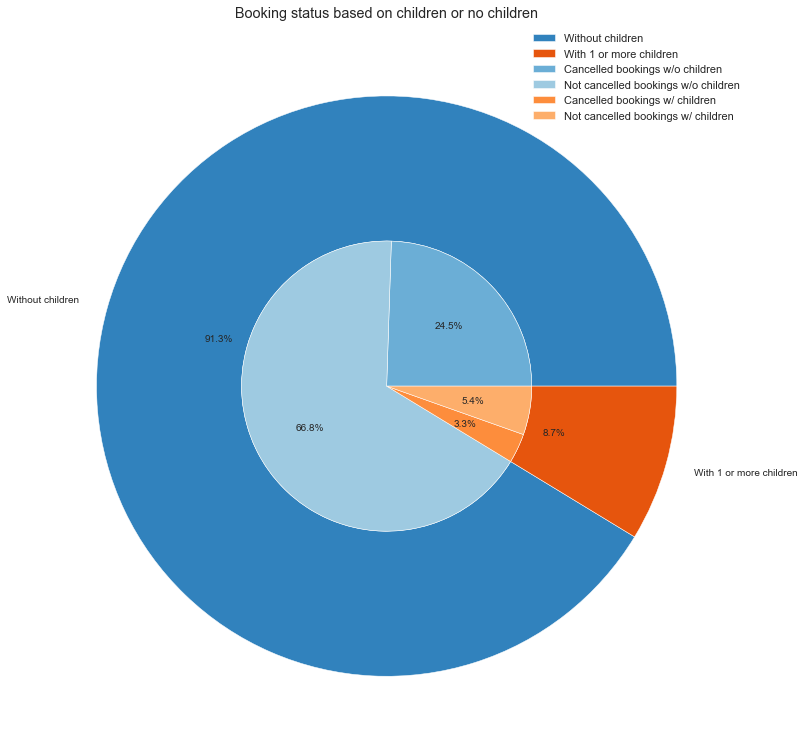

In [714]:
# Children and babies

no_children = df['Children'].value_counts()[0]
with_children = df.loc[(df['Children'] != 0)].shape[0]
total = not_cancelled + cancelled
print(f'Guests with 1 or more children: {(with_children/(total)) * 100:.3f}%\nGuests without children: {(no_children/(total)) * 100:.3f}%')
print() 

cancelled_without_children = df.loc[(df['IsCanceled'] == 1) & (df['Children'] == 0)].shape[0]
print(f'Cancelled bookings for guests with no children: {(cancelled_without_children/no_children) * 100:.3f}%')

cancelled_with_children = df.loc[(df['IsCanceled'] == 1) & (df['Children'] != 0)].shape[0]
print(f'Cancelled bookings for guests with 1 or more children: {(cancelled_with_children/with_children) * 100:.3f}%')
print()

print("The pie chart below represents the distribution between the guests without children and ones with children.\nThe inner circle represents the amount of cancelled vs. uncancelled bookings for both of the categories")
labels = ["Without children", "With 1 or more children"]
labels_inner = ["Cancelled bookings w/o children", "Not cancelled bookings w/o children", "Cancelled bookings w/ children", "Not cancelled bookings w/ children"]
fig, ax = plt.subplots()
size = 0.50
vals = np.array([[cancelled_without_children, no_children - cancelled_without_children], [cancelled_with_children, with_children - cancelled_with_children]])

plt.rcParams["figure.figsize"] = (20,15)
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4)
inner_colors = cmap([1, 2, 5, 6, 9, 10])

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=labels, autopct='%1.1f%%')

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'), labels=labels_inner, labeldistance=None, autopct='%1.1f%%')

ax.set(aspect="equal", title='Booking status based on children or no children')
ax.legend(fontsize=11)

plt.savefig('donutchart.png', bbox_inches='tight')

Total bookings per month:
August       4894
July         4573
April        3609
May          3559
October      3555
March        3336
September    3108
February     3103
June         3045
December     2648
November     2437
January      2193
Name: ArrivalDateMonth, dtype: int64


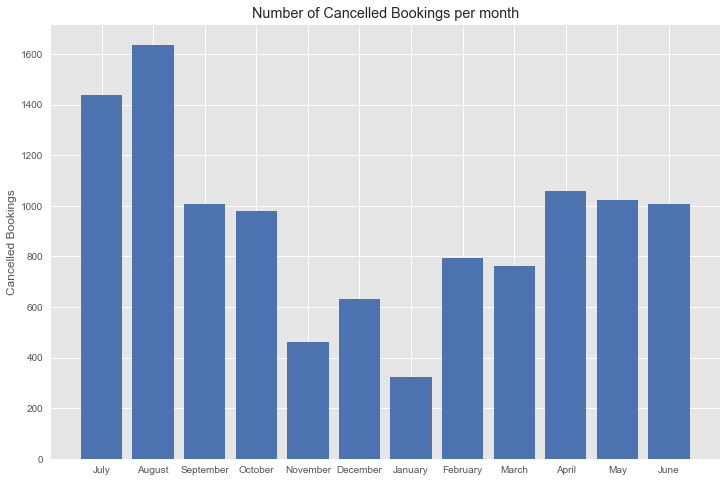

In [719]:
# checking dates most cancelled
dates = df['ArrivalDateMonth'].unique().tolist()
date_values = []
for date in dates:
    date_values.append(df.loc[(df['IsCanceled'] == 1) & (df['ArrivalDateMonth'] == date)].shape[0])
        
plt.rcParams["figure.figsize"] = (12,8)
x_pos = [i for i, _ in enumerate(dates)]
plt.bar(x_pos, date_values)
plt.xticks(x_pos, dates)
plt.ylabel('Cancelled Bookings')
plt.title('Number of Cancelled Bookings per month')
plt.savefig('tourist_months.png', bbox_inches='tight')

print("Total bookings per month:")
print(df['ArrivalDateMonth'].value_counts())

## Handle Missing values

Features with coorelation above 0.95
ArrivalDateWeekNumber
ReservationStatus


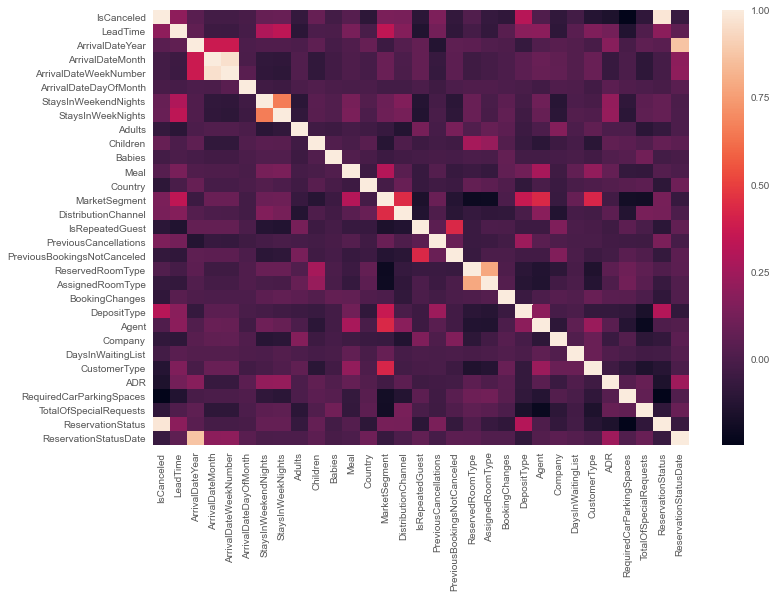

In [720]:
# Create a x and y temporarily to determine feature coorelations
temp_df = df

# Encode catagorical fields
encoder = ce.OrdinalEncoder(cols=temp_df.columns)
temp_df = encoder.fit_transform(temp_df)

corr = temp_df.corr()
heatmap = sns.heatmap(corr)
heatmap.figure.savefig('coorelation_heatmap.png', bbox_inches='tight')

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.95:
            if columns[j]:
                columns[j] = False
selected_columns = temp_df.columns[columns]

print(f'Features with coorelation above 0.95')
for item in temp_df.columns:
    if(item not in selected_columns):
        print(item)

In [571]:
# Remove reservation status and arrival date week number since they have 
if 'ReservationStatus' in df.columns and 'ArrivalDateWeekNumber' in df.columns:
    print('Deleted Reservation Status and Arrival Date Week')
    df = df.drop(['ReservationStatus'], axis=1)
    df = df.drop(['ArrivalDateWeekNumber'], axis=1)
else:
    print('Already deleted')

Deleted Reservation Status and Arrival Date Week


## Encoding categorical columns

In [572]:
# figuring out the values for the categorical columns
# columns not used: arrivaldatemonth, reservationstatusdate
categorical_cols = ['Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'CustomerType']
print('Printing out unique values in each column')

try:
    for column in categorical_cols:
        print(f'{column}: {df[column].unique()}')
        print()
except:
    print("Already encoded, hence these columns do not exist")

Printing out unique values in each column
Meal: ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'Undefined']

Country: ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB'
 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI']

MarketSegment: ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups']

DistributionChannel: [

In [584]:
# Use binary encoder since there are a lot of values for features such as country and room types
# Reduces the curse of dimensionality
# def encode_binary_categorical(df):
try:
    binary_encoder = ce.BinaryEncoder(cols=categorical_cols, handle_missing='return_nan')
    df = binary_encoder.fit_transform(df)
    print('Complete!')
except:
    print('Binary encoding has already been completed')
df.shape

Binary encoding has already been completed


(40060, 63)

#### Encoding Arrival Date Month
Encoding Arrival Date month is done by first ordinally encoding the months, and then a sin and cosine transformation is applied to this feature so that the feature remains cyclical, much like the original concept of months and time. 

In [585]:
# encoding ArrivalDateMonth
try:
    month_encoder = ce.OrdinalEncoder(cols=['ArrivalDateMonth'], return_df=True, 
                                      mapping=[{'col':'ArrivalDateMonth',
                                                'mapping':{'None':0,'January':1,
                                                           'February':2,'March':3,
                                                           'April':4,'May':5, 'June': 6, 
                                                           'July': 7, 'August': 8, 'September': 9, 
                                                           'October': 10, 'November': 11, 'December': 12}}])
    month_encoded_df = month_encoder.fit_transform(df)
    month_encoded_df['ArrivalDateMonthSin'] = np.sin(2 * np.pi * month_encoded_df['ArrivalDateMonth']/12.0)
    month_encoded_df['ArrivalDateMonthCos'] = np.cos(2 * np.pi * month_encoded_df['ArrivalDateMonth']/12.0)
    month_encoded_df.plot.scatter('ArrivalDateMonthSin', 'ArrivalDateMonthCos').set_aspect('equal')
    df = month_encoded_df.drop(['ArrivalDateMonth'], axis=1)
    print('Complete!')
except:
    print('ArrivalDateMonth has already been encoded')
df.shape

ArrivalDateMonth has already been encoded


(40060, 63)

Since the 'ReservationStatusDate' is a string that contains the year, month, and day, this needs to be encoded as well. However, considering the cyclical nature of the days and months, this feature needs to be encoded in the same way as ArrivalDateMonth (as done previously). This encoding process will create 3 new features signifying year, month, and date. 

In [575]:
def splitDateString(value):
    splitted = value.split('-')
    return splitted

if 'ReservationStatusDate' in df.columns:
    # Split date string 
    df['ReservationStatusDate'] = df['ReservationStatusDate'].transform(splitDateString)
    
    # Store year, month, and day as separate features
    df['ReservationStatusYear'] = df['ReservationStatusDate'].str[0]
    df['ReservationStatusMonth'] = df['ReservationStatusDate'].str[1]
    df['ReservationStatusDay'] = df['ReservationStatusDate'].str[2]
    print('Transformed')
    
    # Drop original column which will not be used
    df = df.drop(['ReservationStatusDate'], axis=1)
    print('Value dropped')
else:
    print('Already transformed and dropped column')

# This should add 3 columns, and remove 1
df.shape

Transformed
Value dropped


(40060, 61)

In [578]:
# convert datatype of new columns 
df.ReservationStatusYear = df.ReservationStatusYear.astype(int)
df.ReservationStatusMonth = df.ReservationStatusMonth.astype(int)
df.ReservationStatusDay = df.ReservationStatusDay.astype(int)

df.dtypes

IsCanceled                  int64
LeadTime                    int64
ArrivalDateYear             int64
ArrivalDateDayOfMonth       int64
StaysInWeekendNights        int64
                           ...   
ArrivalDateMonthSin       float64
ArrivalDateMonthCos       float64
ReservationStatusYear       int64
ReservationStatusMonth      int64
ReservationStatusDay        int64
Length: 61, dtype: object

In [579]:
# Perform sin and cosine transformation on both ReservationStatusDay and ReservationStatusMonth
if 'ReservationStatusMonth' in df.columns and 'ReservationStatusDay' in df.columns:
    temp_df = df
    temp_df['ReservationStatusMonthSin'] = np.sin(2 * np.pi * temp_df['ReservationStatusMonth']/12.0)
    temp_df['ReservationStatusMonthCos'] = np.cos(2 * np.pi * temp_df['ReservationStatusMonth']/12.0)

    temp_df['ReservationStatusDaySin'] = np.sin(2 * np.pi * temp_df['ReservationStatusDay']/31.0)
    temp_df['ReservationStatusDayCos'] = np.cos(2 * np.pi * temp_df['ReservationStatusDay']/31.0)
    df = temp_df.drop(['ReservationStatusMonth', 'ReservationStatusDay'], axis=1)
else:
    print('Process has already completed')
# this should create 4 columns, and drop 2
df.shape

(40060, 63)

## Impute Data
#### Missing Values 
The columns of "Country", "Agent", and "Company" have missing values. At a later step, these values will be imputed with the help of a prediction model. Additionally, the "Company" feature column will be removed since there is a significant amount of missing data. Such features with a significant amount of missing values are rarely good features for training models. 

"Country_0" column contains 464 missing values, 1.158%
"Country_1" column contains 464 missing values, 1.158%
"Country_2" column contains 464 missing values, 1.158%
"Country_3" column contains 464 missing values, 1.158%
"Country_4" column contains 464 missing values, 1.158%
"Country_5" column contains 464 missing values, 1.158%
"Country_6" column contains 464 missing values, 1.158%
"Country_7" column contains 464 missing values, 1.158%
"Agent" column contains 8209 missing values, 20.492%
"Company" column contains 36952 missing values, 92.242%


<AxesSubplot:>

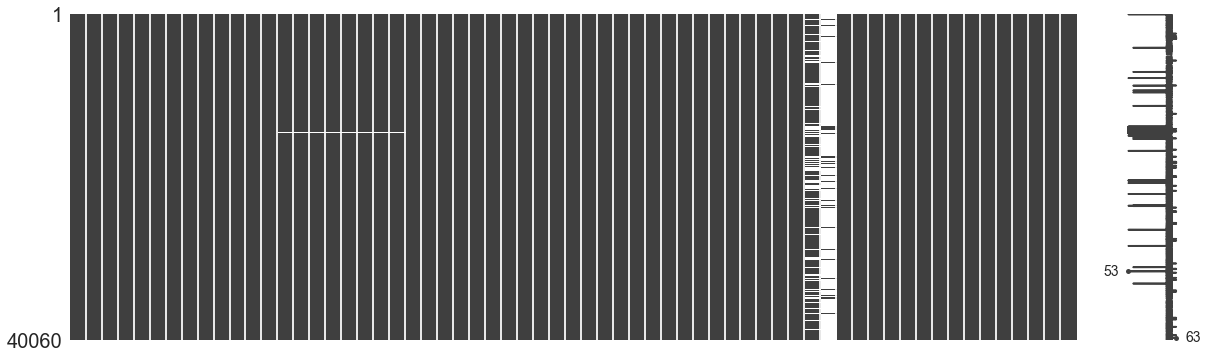

In [339]:
# count missing values
num_rows = df.shape[0]
missing_values = df.isnull().sum()
for i in range(0, len(df.columns)):
    if(missing_values[i] > 0):
        print(f'"{df.columns[i]}" column contains {missing_values[i]} missing values, {(missing_values[i]/num_rows)*100:.3f}%')
        
mno.matrix(df, figsize = (20, 6))

The feature *Country* is not missing a significant amount of data (only missing 1.158%), and thus those rows can be removed from the dataset to make it easier to impute values in the other columns. 

In [340]:
# Remove rows with nan values in country
df = df[df['Country_1'].notna()]

In [341]:
# Split dataset 
x = df.drop(['IsCanceled'], axis=1)
y = df['IsCanceled']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=10)
print(f'DIMENSIONS\nx train: {x_train.shape}\nx test: {x_test.shape}\ny train: {y_train.shape}\ny test: {y_test.shape}')

DIMENSIONS
x train: (31676, 62)
x test: (7920, 62)
y train: (31676,)
y test: (7920,)


In [342]:
# Remove Company feature, since there are too many missing values in this feature
if 'Company' in x_train and 'Company' in x_test:
    print('Deleted Company')
    x_train = x_train.drop(['Company'], axis=1)
    x_test = x_test.drop(['Company'], axis=1)
else:
    print('Already deleted')
# deleted 1 column, originally started with 66
x_train.shape, x_test.shape

Deleted Company


((31676, 61), (7920, 61))

In [343]:
# count missing values again
num_rows = x_train.shape[0]
missing_values = x_train.isnull().sum()
for i in range(0, len(x_train.columns)):
    if(missing_values[i] > 0):
        print(f'"{x_train.columns[i]}" column contains {missing_values[i]} missing values, {(missing_values[i]/num_rows)*100:.3f}%')

"Agent" column contains 6296 missing values, 19.876%


In [345]:
# Impute agent using KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)
x_train = pd.DataFrame(knn_imputer.fit_transform(x_train), columns=x_train.columns)

In [346]:
num_rows = x_train.shape[0]
missing_values = x_train.isnull().sum()
for i in range(0, len(x_train.columns)):
    if(missing_values[i] > 0):
        print(f'"{x_train.columns[i]}" column contains {missing_values[i]} missing values, {(missing_values[i]/num_rows)*100:.3f}%')

In [347]:
print(f'NaN values in the training set: {x_train.isnull().sum().sum()}')

NaN values in the training set: 0


In [348]:
# impute items in the test set
x_test = pd.DataFrame(knn_imputer.transform(x_test), columns=x_test.columns)

In [349]:
print(f'NaN values in the test set: {x_test.isnull().sum().sum()}')

NaN values in the test set: 0


## Classifiers

In [357]:
# decision tree
tree_clf = DecisionTreeClassifier().fit(x_train, y_train)

print(f'Cross Validation:\n{cross_val_score(tree_clf, x_train, y_train, cv=5)}')
print()

tree_predictions = tree_clf.predict(x_test)
print(f'Decision Tree model accuracy score on test data:\n{accuracy_score(y_test, tree_predictions):.4f}\n')
print(f'Confusion matrix:\n{confusion_matrix(y_test, tree_predictions)}\n')
print(f'Classification report:\n{classification_report(y_test, tree_predictions)}')

Cross Validation:
[0.91666667 0.9261247  0.91570639 0.92375691 0.92186267]

Decision Tree model accuracy score on test data:
0.9192

Confusion matrix:
[[5382  335]
 [ 305 1898]]

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5717
           1       0.85      0.86      0.86      2203

    accuracy                           0.92      7920
   macro avg       0.90      0.90      0.90      7920
weighted avg       0.92      0.92      0.92      7920



In [358]:
# mlp classifier 
mlp_clf = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=500).fit(x_train, y_train)

print(f'\nCross Validation Scores:\n{cross_val_score(mlp_clf, x_train, y_train, cv=5)}\n')

mlp_predictions = mlp_clf.predict(x_test)
print(f'MLP Classifier accuracy score on test data:\n{accuracy_score(y_test, predictions):.4f}\n')
print(f'Confusion matrix:\n{confusion_matrix(y_test, predictions)}\n')
print(f'Classification report:\n{classification_report(y_test, predictions)}')


Cross Validation Scores:
[0.84674874 0.84625099 0.84672455 0.84198895 0.82951855]

MLP Classifier accuracy score on test data:
0.8491

Confusion matrix:
[[5494  223]
 [ 972 1231]]

Classification report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5717
           1       0.85      0.56      0.67      2203

    accuracy                           0.85      7920
   macro avg       0.85      0.76      0.79      7920
weighted avg       0.85      0.85      0.84      7920



In [359]:
print(f'The decision tree is {(accuracy_score(y_test, tree_predictions) - accuracy_score(y_test, predictions)) * 100:.4f}% more accurate than MLP classifier')

The decision tree is 7.0076% more accurate than MLP classifier


In [360]:
# Random Forest Model
forest_clf = RandomForestClassifier().fit(x_train, y_train)

print(f'\nCross Validation Scores:\n{cross_val_score(forest_clf, x_train, y_train, cv=5)}\n')

randForest_predictions = forest_clf.predict(x_test)
print(f'Random Forest model accuracy score on test data:\n{accuracy_score(y_test, predictions_randForest):.4f}\n')
print(f'Confusion matrix:\n{confusion_matrix(y_test, predictions_randForest)}\n')
print(f'Classification report:\n{classification_report(y_test, predictions_randForest)}')


Cross Validation Scores:
[0.94917929 0.94996054 0.94522494 0.94396212 0.95295975]

Random Forest model accuracy score on test data:
0.9515

Confusion matrix:
[[5658   59]
 [ 325 1878]]

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5717
           1       0.97      0.85      0.91      2203

    accuracy                           0.95      7920
   macro avg       0.96      0.92      0.94      7920
weighted avg       0.95      0.95      0.95      7920



In [361]:
print(f'The random forest model is {(accuracy_score(y_test, predictions_randForest) - accuracy_score(y_test, tree_predictions)) * 100:.4f}% more accurate than Decision Tree')

The random forest model is 3.2323% more accurate than Decision Tree


### Tuning Hyperparameters

In [366]:
# Grid search for Decision Tree model
parameters = {'criterion' : ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [None, 2, 4, 16, 32],
              'min_samples_split': [2, 4, 8, 16],
              'min_samples_leaf': [1, 2, 4, 8],
              'max_features' : [None, 'auto', 'sqrt', 'log2']
             }

gridClf = GridSearchCV(DecisionTreeClassifier(), parameters, cv=3)
gridClf.fit(x_train, y_train)
print("Grid search completed.")

print("\nHere are the best parameters for Decision Tree:", gridClf.best_params_, "\n")

Grid search completed.

Here are the best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 8, 'splitter': 'best'} 



In [391]:
# Grid search for Random Forest model
parameters = {'criterion' : ['gini', 'entropy'],
              'min_samples_split': [2, 3, 4],
              'max_depth': [None, 10, 50, 100, 200],
              'max_features': ["auto", "sqrt", "log2"]
             }

gridClf = GridSearchCV(RandomForestClassifier(), parameters, cv=3)
gridClf.fit(x_train, y_train)
print("Grid search completed.")

print("\nHere are the best parameters for Random Forest:", gridClf.best_params_, "\n")

Grid search completed.

Here are the best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto', 'min_samples_split': 3} 



In [370]:
# Grid search for Multilayer Perceptron model
parameters = {'solver': ['adam', 'lbfgs', 'sgd'], 
              'activation': ['identity', 'logistic', 'tanh', 'relu'],
              'hidden_layer_sizes': [(10,10,10), (10, 5), (100, 10, 50)],
              'alpha': [.0001, .005], 
              'learning_rate': ['constant', 'adaptive', 'invscaling']}

gridClf = GridSearchCV(MLPClassifier(), parameters, cv=3).fit(x_train, y_train)
print("Grid search completed.")

print("\nHere are the best parameters for MLP:",gridClf.best_params_,"\n")

Grid search completed.

Here are the best parameters for MLP: {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (100, 10, 50), 'learning_rate': 'constant', 'solver': 'adam'} 



### Creating models with the best parameters returned from grid search

In [377]:
# decision tree 
tuned_tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=8, splitter='best').fit(x_train, y_train)

tuned_tree_predictions = tuned_tree_clf.predict(x_test)
print(f'Tuned Decision Tree model accuracy score on test data:\n{accuracy_score(y_test, tuned_tree_predictions):.4f}\n')

Tuned Decision Tree model accuracy score on test data:
0.9210



In [395]:
# Random Forest Model
tuned_forest_clf = RandomForestClassifier(criterion='entropy', max_depth=100, max_features='auto', min_samples_split=3).fit(x_train, y_train)

tuned_predictions_randForest = tuned_forest_clf.predict(x_test)
print(f'Tuned Random Forest model accuracy score on test data:\n{accuracy_score(y_test, tuned_predictions_randForest):.4f}\n')

Tuned Random Forest model accuracy score on test data:
0.9516



In [586]:
# mlp classifier 
tuned_mlp_clf = MLPClassifier(activation='relu', alpha=0.005, hidden_layer_sizes=(100,10,50), learning_rate='constant', solver='adam').fit(x_train, y_train)

tuned_predictions_mlp = tuned_mlp_clf.predict(x_test)
print(f'Tuned MLP Classifier accuracy score on test data:\n{accuracy_score(y_test, tuned_predictions_mlp):.4f}\n')

Tuned MLP Classifier accuracy score on test data:
0.8832



In [724]:
# difference between untuned and tuned accuracy scores
decisionTree = accuracy_score(y_test, tuned_tree_predictions) - accuracy_score(y_test, tree_predictions)
randomForest = accuracy_score(y_test, tuned_predictions_randForest) - accuracy_score(y_test, predictions_randForest)
mlpClassifier = accuracy_score(y_test, tuned_predictions_mlp) - accuracy_score(y_test, mlp_predictions)

print(f'Tuned Decision Tree accuracy gain: {decisionTree:.4f} or {decisionTree * 100:.4f}%')
print(f'Tuned Random Forest accuracy gain: {randomForest:.4f} or {randomForest * 100:.4f}%')
print(f'Tuned MLP Classifier accuracy gain: {mlpClassifier:.4f} or {mlpClassifier * 100:.4f}%')

Tuned Decision Tree accuracy gain: 0.0018 or 0.1768%
Tuned Random Forest accuracy gain: 0.0001 or 0.0126%
Tuned MLP Classifier accuracy gain: 0.0472 or 4.7222%


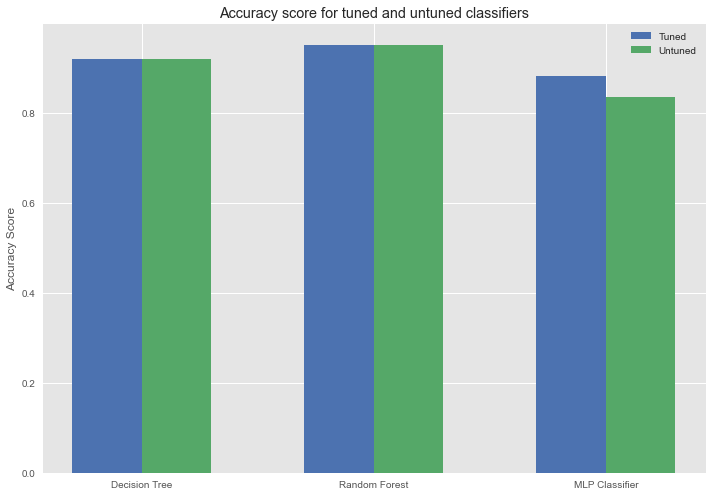

In [725]:
plt.style.use('seaborn-deep')

tuned = np.array([accuracy_score(y_test, tuned_tree_predictions), accuracy_score(y_test, tuned_predictions_randForest), accuracy_score(y_test, tuned_predictions_mlp)])
untuned = np.array([accuracy_score(y_test, tree_predictions), accuracy_score(y_test, predictions_randForest), accuracy_score(y_test, mlp_predictions)])
labels = ['Decision Tree', 'Random Forest', 'MLP Classifier']

x = np.arange(len(labels))
width = 0.30

plt.rcParams["figure.figsize"] = (10,7)

fig, ax = plt.subplots()
tuned_bar = ax.bar(x - width/2, tuned, width, label='Tuned')
untuned_bar = ax.bar(x + width/2, untuned, width, label='Untuned')

ax.set_ylabel('Accuracy Score')
ax.set_title('Accuracy score for tuned and untuned classifiers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.savefig('classifier_results.png', bbox_inches='tight')

In [634]:
# checking for overfitting and underfitting 
print("Checking for overfitting and underfitting\n")
tree_train_predictions = tuned_tree_clf.predict(x_train)
forest_train_predictions = tuned_forest_clf.predict(x_train)
mlp_train_predictions = tuned_mlp_clf.predict(x_train)

print("Decision tree:")
print(f'Training set accuracy score: {accuracy_score(y_train, tree_train_predictions):.4f}')
print(f'Test set accuracy score: {accuracy_score(y_test, tuned_tree_predictions):.4f}\n')

print("Random Forest:")
print(f'Training accuracy set score: {accuracy_score(y_train, forest_train_predictions):.4f}')
print(f'Test set accuracy score: {accuracy_score(y_test, tuned_predictions_randForest):.4f}\n')

print("MLP Classifier:")
print(f'Training accuracy set score: {accuracy_score(y_train, mlp_train_predictions):.4f}')
print(f'Test set accuracy score: {accuracy_score(y_test, tuned_predictions_mlp):.4f}\n')

Checking for overfitting and underfitting

Decision tree:
Training set accuracy score: 0.9704
Test set accuracy score: 0.9210

Random Forest:
Training accuracy set score: 0.9995
Test set accuracy score: 0.9516

MLP Classifier:
Training accuracy set score: 0.8899
Test set accuracy score: 0.8832

